## Thymus scRNA-seq EDA 

In [2]:
import os,sys
import scanpy as sc
import pandas as pd
import numpy as np
## To show plots inline
import matplotlib.pyplot as plt
# plt.switch_backend('agg')
sys.path.insert(1, '/nfs/team205/ed6/bin/thATAC/preprocess_utils/')
import atac_utils 
import scipy.sparse
import seaborn as sns

import sklearn.preprocessing

### Load raw data

Datasets were downloaded from [here](https://zenodo.org/record/3572422#.XsY2h5NKhQI) following the link from [Park et al. 2020](10.1126/science.aay3224)

In [3]:
## Raw counts
rna_adata = sc.read_h5ad("/nfs/team205/ed6/data/Park_scRNAseq/HTA07.A01.v02.entire_data_raw_count.h5ad?download=1")
rna_adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
# ## Filtered tcell data (only good quality cells from fetal samples)
t_adata = sc.read_h5ad("/nfs/team205/ed6/data/Park_scRNAseq/HTA08.v01.A06.Science_human_tcells.raw.h5ad")
t_adata.var_names_make_unique()

t_adata.raw = rna_adata[t_adata.obs_names]

Select only CD45+ and TOT sort cells

In [5]:
t_adata = t_adata[t_adata.obs.sort.isin(["45P", "TOT"])]

### Dimensionality reduction

Exclude cell cycle genes (copied from supplementary info in Park et al.2020)

In [6]:
cc_genes = ['C1orf112', 'KDM1A', 'ARHGAP33', 'CDC27', 'AC004381.6', 'DBF4', 'PRSS21', 'E2F2', 'BAZ1B', 'NCAPD2', 'ANLN', 'BRCA1', 'UBR7', 'DDX11', 'TACC3', 'POLA2', 'DEPDC1', 'NCAPH2', 'HMGB3', 'CENPQ', 'DEPDC1B', 'SPDL1', 'TDP1', 'DSG2', 'NOP16', 'RFC2', 'RAD51', 'POLQ', 'THOC3', 'MRTO4', 'C4orf27', 'POLD1', 'TM7SF3', 'MCM10', 'MTHFD2', 'YBX1', 'ASPM', 'PRR11', 'NUCKS1', 'EXOC5', 'TCOF1', 'RAD18', 'TRIP13', 'DAZAP1', 'HLTF', 'PDCD2', 'SMC1A', 'HMMR', 'MCM2', 'NUP37', 'GTSE1', 'WDR62', 'MCM6', 'MLH1', 'UNG', 'SPAG5', 'UBE2T', 'EXOSC5', 'FAM76B', 'POLD3', 'KIF22', 'PUM3', 'RBL1', 'NDC80', 'HSPB11', 'OXCT1', 'SEH1L', 'ORC1', 'RAD54L', 'NOP14', 'GMCL1', 'AURKA', 'TPX2', 'BIRC5', 'KIF4A', 'FH', 'ORC6', 'G2E3', 'WDR76', 'PHGDH', 'CLSPN', 'NUP50', 'CDC45', 'CDC6', 'CBX5', 'MSH2', 'FKBP5', 'ACOT7', 'CDC7', 'RANBP1', 'CENPM', 'HMGXB4', 'MCM5', 'RANGAP1', 'POLE2', 'CDKN3', 'ERH', 'MTHFD1', 'VRK1', 'EMC9', 'GINS1', 'MYBL2', 'CDC25B', 'PLCB4', 'FAM83D', 'CEP76', 'RBBP8', 'POLA1', 'NUP93', 'CTCF', 'CCP110', 'CEP152', 'OIP5', 'MYEF2', 'MCM4', 'KCTD9', 'RNASEH2A', 'SGTA', 'ASF1B', 'LIG1', 'H2AFV', 'GARS', 'NUDT1', 'RPA3', 'EZH2', 'RHEB', 'SMC3', 'UBE2S', 'RAD51C', 'GALK1', 'C1QBP', 'BLMH', 'TMEM97', 'GAR1', 'NEIL3', 'WHSC1', 'NCAPG', 'CCDC34', 'CCDC86', 'MAGOHB', 'FOXM1', 'GPN3', 'RAD51AP1', 'RFC5', 'NUP107', 'TIMELESS', 'GAPDH', 'CDCA3', 'ENO2', 'FBXO5', 'MCM3', 'BAG2', 'GMNN', 'TTK', 'HMGCS1', 'BRD8', 'KIF20A', 'LMNB1', 'NUP155', 'H2AFY', 'SMC4', 'ECT2', 'CENPA', 'FHL2', 'MSH6', 'DHCR24', 'LRRC42', 'WDR77', 'SRM', 'MAD2L2', 'UCHL5', 'TTF2', 'SLC2A1', 'EBNA1BP2', 'CDC20', 'STMN1', 'NEK2', 'CENPF', 'KIF14', 'CASP8AP2', 'CTNNAL1', 'WDR34', 'PHF19', 'ACYP1', 'EPCAM', 'HELLS', 'CENPL', 'ACAT2', 'MASTL', 'EXOSC8', 'TMPO', 'NFYB', 'NCAPH', 'MND1', 'KIF18A', 'GPSM2', 'GTF3A', 'MRPS2', 'CCDC18', 'CISD1', 'ZWINT', 'CIT', 'DDX39A', 'CENPK', 'CDK2', 'TUBA1B', 'STIL', 'HJURP', 'EXOSC9', 'CKS2', 'ACSL3', 'CSE1L', 'HIST1H1D', 'HIST1H1A', 'DEK', 'GOT2', 'MGME1', 'MCM8', 'HNRNPR', 'BCL2L12', 'TRAP1', 'DLGAP5', 'YEATS4', 'PKMYT1', 'SRD5A3', 'PAICS', 'HAT1', 'KNSTRN', 'DUT', 'E2F8', 'FAM64A', 'MIS18BP1', 'SGOL1', 'RPS4Y1', 'LDLR', 'TOMM40', 'ATP8B3', 'LSM4', 'DNMT1', 'GINS2', 'TUBG1', 'PSMC3IP', 'THOC6', 'TOP2A', 'ENOSF1', 'RAN', 'RPA1', 'PCNA', 'NASP', 'RFC3', 'SLF1', 'LRRCC1', 'CCNB1', 'PSRC1', 'TMEM106C', 'LDHA', 'DDB2', 'CDCA8', 'TPGS2', 'SLC43A3', 'C9orf40', 'TROAP', 'ESPL1', 'NTPCR', 'CKAP2', 'BORA', 'NUDT15', 'BRIP1', 'ACTL6A', 'TXN', 'ODF2', 'SMC2', 'CDK5RAP2', 'ANP32B', 'DSCC1', 'ARHGEF39', 'PPIL1', 'TCF19', 'NRM', 'GGH', 'BUD13', 'CTDSPL2', 'NUSAP1', 'KIF23', 'CASC5', 'CENPO', 'KIF11', 'CEP55', 'KIF20B', 'DNA2', 'BARD1', 'MNS1', 'ZGRF1', 'CENPE', 'HADH', 'SLC39A8', 'NEDD1', 'BRCA2', 'DIAPH3', 'PIF1', 'FANCI', 'TICRR', 'SAMD1', 'SAE1', 'PLK4', 'ITGB3BP', 'KIF2C', 'UCK2', 'NUF2', 'ANP32E', 'DTL', 'ILF2', 'C1orf35', 'HNRNPLL', 'CHAC2', 'POLR2D', 'CDCA7', 'FANCD2', 'CCNA2', 'SKP2', 'PRIM2', 'MMS22L', 'PM20D2', 'MTFR2', 'CDCA5', 'NCAPG2', 'PRPS1', 'GINS4', 'HAUS6', 'CEP78', 'GTF3C5', 'MKI67', 'IMMP1L', 'SSRP1', 'INCENP', 'CCDC15', 'CHEK1', 'DSN1', 'HIRIP3', 'HMGA2', 'TEX30', 'NCAPD3', 'CENPU', 'CENPJ', 'SPC25', 'SUV39H2', 'CENPH', 'CARHSP1', 'CLGN', 'CCSAP', 'BUB3', 'SLFN13', 'SKA1', 'SLC16A1', 'TMEM237', 'ADK', 'FAM122B', 'AIFM1', 'ATAD2', 'SASS6', 'BUB1B', 'CCNB2', 'PSMG3', 'FAIM', 'CDC25C', 'MIS18A', 'ATP5G1', 'IGF2BP1', 'CHAF1B', 'NAE1', 'CCDC58', 'C21orf58', 'ZNF714', 'GPATCH4', 'YDJC', 'RACGAP1', 'SPC24', 'POLR3K', 'CCNF', 'ASRGL1', 'USP1', 'KIAA1524', 'SGOL2', 'TOPBP1', 'KIF15', 'WDR43', 'RFC4', 'RPL39L', 'RNF168', 'H2AFZ', 'CDC25A', 'POC1A', 'HMGB2', 'MAD2L1', 'PTTG1', 'RAD21', 'PSIP1', 'GKAP1', 'MELK', 'SLC7A3', 'SKA3', 'LRR1', 'HPRT1', 'E2F7', 'JAM3', 'BRD7', 'CENPN', 'LEO1', 'WEE1', 'MCM7', 'CENPV', 'SAAL1', 'FAM111A', 'KIAA0101', 'PLK1', 'XRCC6BP1', 'SNRPD1', 'RRM1', 'CDT1', 'CHAF1A', 'C19orf48', 'NUDT8', 'PRDX2', 'TK1', 'SAC3D1', 'PBK', 'HIST1H1E', 'DTYMK', 'RFWD3', 'FEN1', 'ING2', 'CDKN2AIP', 'SNRNP48', 'USP39', 'CKAP2L', 'BUB1', 'ELP5', 'CDK1', 'CDCA4', 'SHCBP1', 'PGAM1', 'ESCO2', 'RHNO1', 'CTPS1', 'RRM2', 'THOP1', 'C5orf34', 'POP7', 'ZNF738', 'CKS1B', 'GMPPB', 'CNP', 'CBX2', 'C16orf91', 'EXO1', 'ZWILCH', 'ANKRD36C', 'UBE2C', 'CKAP5', 'CCNE2', 'CCDC14', 'RMI2', 'TOMM5', 'RUVBL1', 'ATAD5', 'LMNB2', 'TYMS', 'PXMP2', 'SHMT1', 'POLE', 'PAWR', 'PIDD1', 'GSG2', 'GEN1', 'RMI1', 'AURKB', 'RCC1', 'PPA1', 'HIST3H2A', 'MRPS23', 'RTKN2', 'IDH2', 'KPNA2', 'CEP97', 'GLRX5', 'SKA2', 'CEP57L1', 'PSMG1', 'SFXN4', 'ALYREF', 'TRAIP', 'LIN9', 'KMT5A', 'PGP', 'CMSS1', 'HIST2H2AC', 'HIST1H1B', 'KNTC1', 'CDCA2', 'H1FX', 'SIVA1', 'PARPBP', 'KIF18B', 'ERCC6L', 'PTMA', 'HSPA14', 'FANCA', 'ARHGAP11B', 'TUBB4B', 'CENPP', 'H2AFX', 'FAM72B', 'FAM221A', 'FAM111B', 'HN1', 'HMGB1', 'TUBB', 'IARS', 'ERI2', 'HIST1H4C', 'BLM', 'PRIM1', 'HMGN5', 'SVIP', 'TFDP1', 'TXNRD1', 'WDHD1', 'EIF1AY', 'ARHGAP11A', 'HMGN2', 'DCAF12', 'PRC1', 'CCDC167', 'CENPW', 'GPANK1', 'MZT1', 'C4orf46', 'KLHL23', 'MXD3', 'DNAJC9', 'IFRD2', 'CKLF', 'FANCG', 'DHFR', 'DLEU2', 'AP000251.3', 'KIFC1', 'CRNDE', 'C8orf88', 'PRKDC', 'BOP1', 'RP11-196G18.23', 'CTC-260E6.6', 'NCBP2-AS2', 'HIST1H3G', 'HIST1H2AH', 'UHRF1', 'RDM1', 'HIST1H2AM']
t_adata_process = t_adata[:,[x not in cc_genes for x in t_adata.var_names]]

In [7]:
def sc_process(adata,pid = 'fpnul',n_pcs=50):
    if 'f' in pid:
        sc.pp.filter_genes_dispersion(adata)
    if 's' in pid:
        sc.pp.scale(adata,max_value=10)
    if 'p' in pid:
        sc.pp.pca(adata)
    if 'n' in pid:
        sc.pp.neighbors(adata,n_pcs=n_pcs)
    if 'u' in pid:
        sc.tl.umap(adata)
    if 'l' in pid:
        sc.tl.leiden(adata)

In [8]:
sc_process(t_adata_process, pid="fpnu")

Trying to set attribute `.var` of view, copying.
/home/jovyan/.local/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".local/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/home/jovyan/.local/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".local/lib/python3.7/site-packages/u

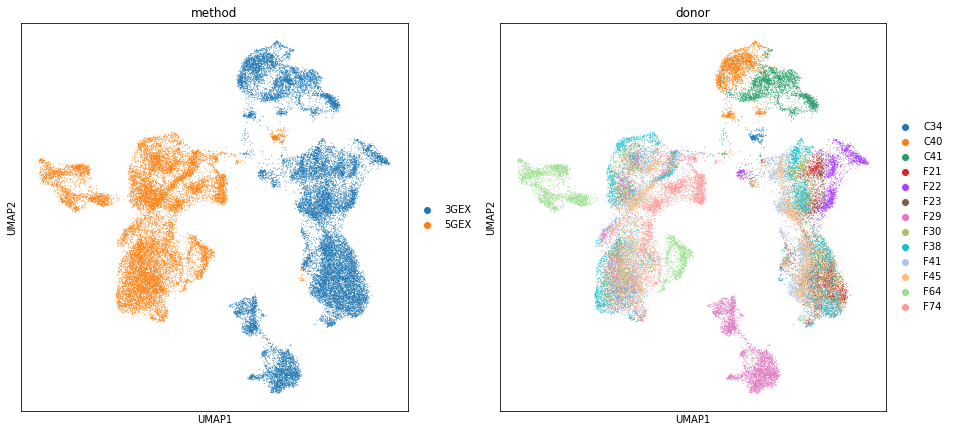

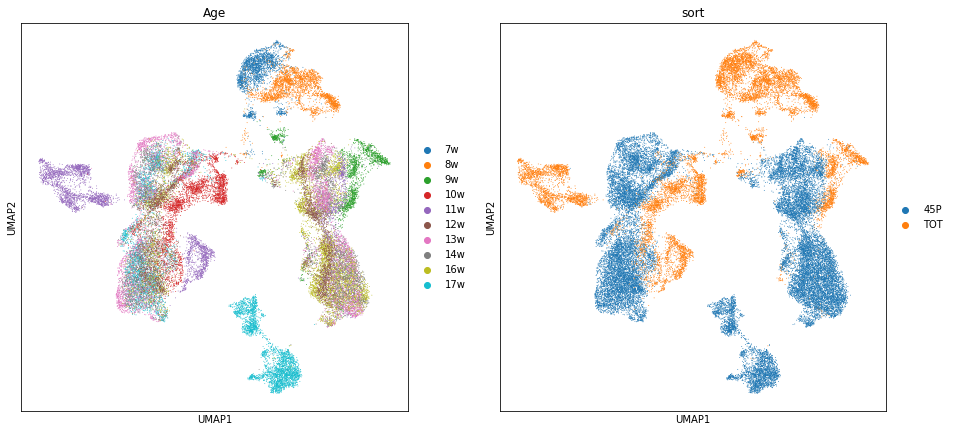

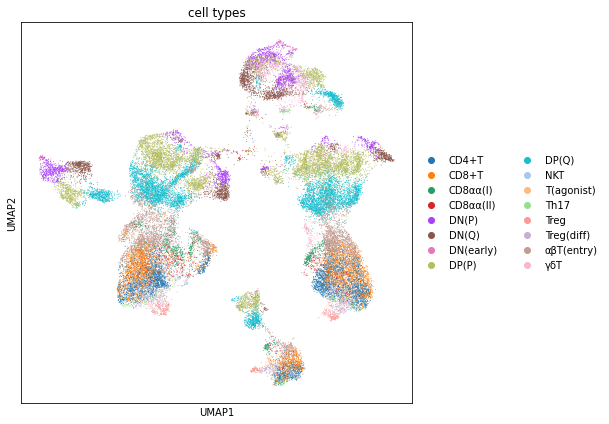

In [9]:
plt.rcParams["figure.figsize"] = [7,7]
sc.pl.umap(t_adata_process, color=["method", "donor"])
sc.pl.umap(t_adata_process, color=["Age","sort"])
sc.pl.umap(t_adata_process, color=["cell types"])


## Batch correction w BBKNN

Try different correction variables, making sure the graph always has ~ 20 nearest neighbors

#### Correct by method

In [10]:
t_adata_bbknn1 = t_adata_process.copy()
sc.external.pp.bbknn(t_adata_bbknn1, batch_key="method")

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/bbknn/__init__.py:289: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/bbknn/__init__.py:290: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


In [11]:
sc.tl.umap(t_adata_bbknn1)

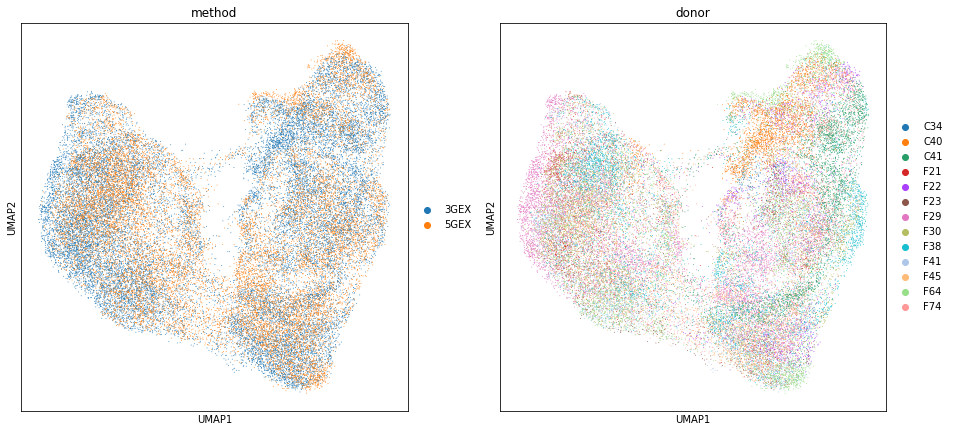

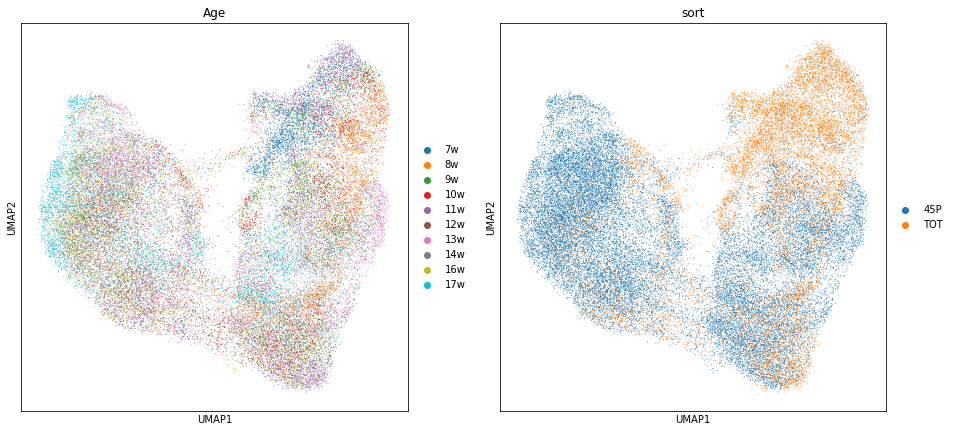

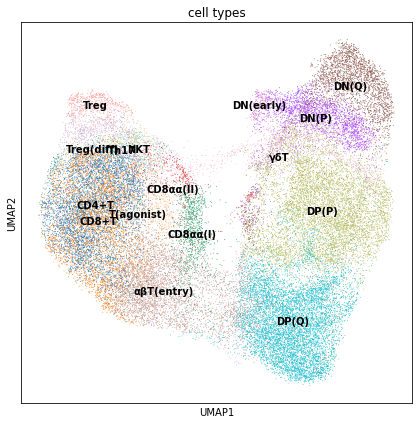

In [12]:
sc.pl.umap(t_adata_bbknn1, color=["method", "donor"])
sc.pl.umap(t_adata_bbknn1, color=["Age","sort"])
sc.pl.umap(t_adata_bbknn1, color=["cell types"], legend_loc="on data")

#### Correct by donor

In [13]:
t_adata_bbknn2 = t_adata_bbknn1.copy()
sc.external.pp.bbknn(t_adata_bbknn2, batch_key="donor")

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/bbknn/__init__.py:289: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/bbknn/__init__.py:290: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


In [14]:
sc.tl.umap(t_adata_bbknn2)

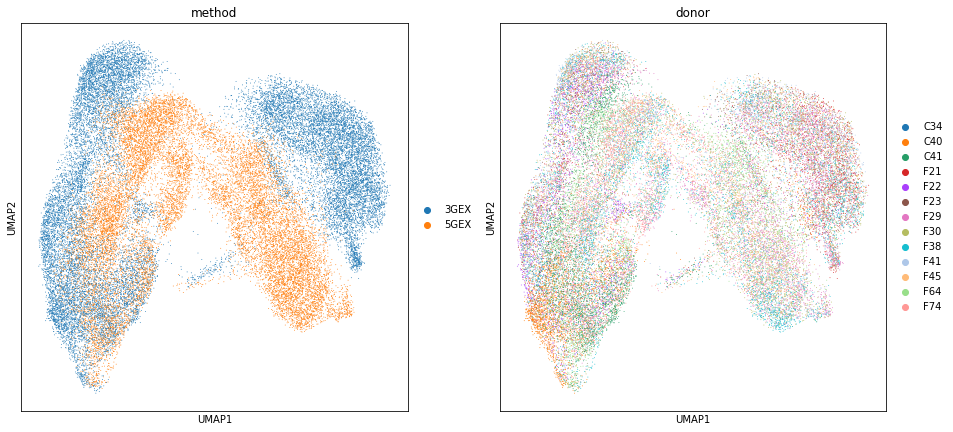

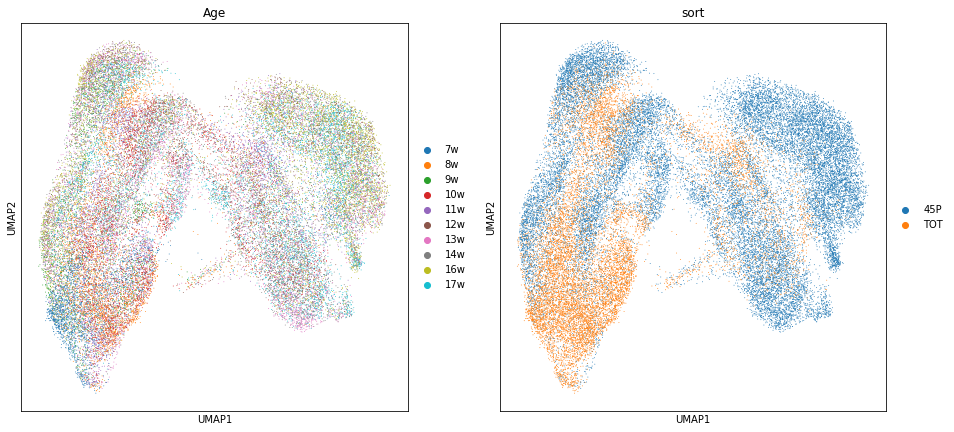

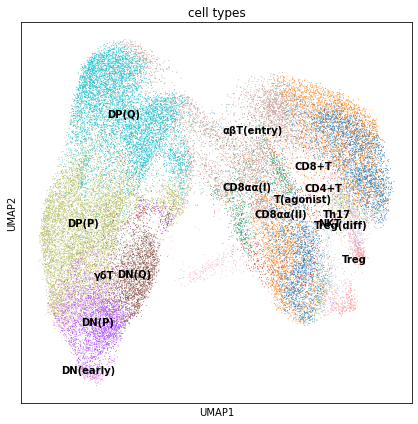

In [15]:
sc.pl.umap(t_adata_bbknn2, color=["method", "donor"])
sc.pl.umap(t_adata_bbknn2, color=["Age","sort"])
sc.pl.umap(t_adata_bbknn2, color=["cell types"], legend_loc="on data")

#### Correct by method and donor

Similarly to original paper

In [11]:
t_adata_bbknn3 = t_adata_process.copy()
## Add donor + method column
donor_method = [t_adata_bbknn3.obs.donor.values[i] + "_" + t_adata_bbknn3.obs.method.values[i]  for i in range(len(t_adata_bbknn3.obs.donor.values))]

t_adata_bbknn3.obs['donor_method'] = donor_method

sc.external.pp.bbknn(t_adata_bbknn3, batch_key="donor_method")

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/bbknn/__init__.py:289: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/bbknn/__init__.py:290: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


In [12]:
sc.tl.umap(t_adata_bbknn3)

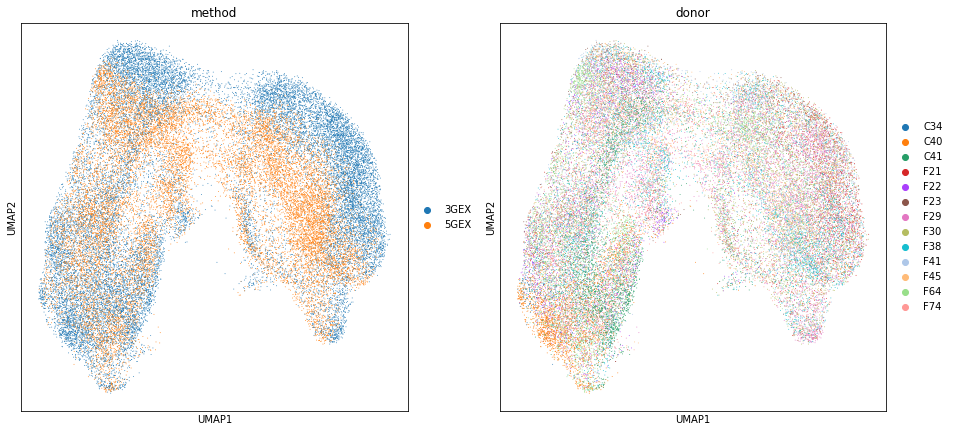

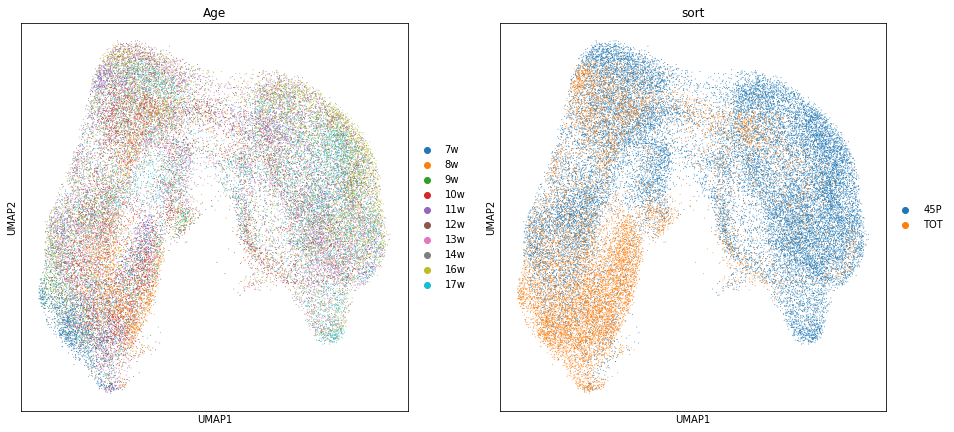

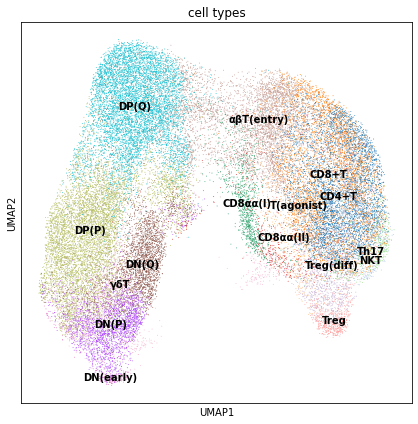

In [14]:
sc.pl.umap(t_adata_bbknn3, color=["method", "donor"])
sc.pl.umap(t_adata_bbknn3, color=["Age","sort"])
sc.pl.umap(t_adata_bbknn3, color=["cell types"], legend_loc="on data")

Save the distance matrices 

In [22]:
scipy.io.mmwrite('/nfs/team205/ed6/data/Park_scRNAseq/HTA08.v01.A06.Science_human_tcells_BBKNNtest.uncorrectedDist',t_adata_process.obsp["distances"])
scipy.io.mmwrite('/nfs/team205/ed6/data/Park_scRNAseq/HTA08.v01.A06.Science_human_tcells_BBKNNtest.methodDist',t_adata_bbknn1.obsp["distances"])
scipy.io.mmwrite('/nfs/team205/ed6/data/Park_scRNAseq/HTA08.v01.A06.Science_human_tcells_BBKNNtest.donorDist',t_adata_bbknn2.obsp["distances"])
scipy.io.mmwrite('/nfs/team205/ed6/data/Park_scRNAseq/HTA08.v01.A06.Science_human_tcells_BBKNNtest.donormethodDist',t_adata_bbknn3.obsp["distances"])


Save PCA matrix used to make KNN graphs

In [118]:
pc_df = pd.DataFrame(t_adata_process.obsm["X_pca"], index=t_adata_process.obs_names, columns=["PC" + str(x+1) for x in range(t_adata_process.obsm["X_pca"].shape[1])])

In [119]:
pc_df.to_csv('/nfs/team205/ed6/data/Park_scRNAseq/HTA08.v01.A06.Science_human_tcells_BBKNNtest.PCA.csv')

Save anndata object of main correction dataset

In [15]:
t_adata_bbknn3.write_h5ad('/nfs/team205/ed6/data/Park_scRNAseq/HTA08.v01.A06.Science_human_tcells_BBKNN.donormethodDist.h5ad')

---
---
### Junk n snippets